# Previsão de Atraso de Avião — Gabarito com CatBoost e SHAP

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from catboost import CatBoostClassifier, Pool
import shap

df = pd.read_csv("Airlines.csv")
df.head()


,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [2]:

df.info()
df.describe(include="all")
df.isna().sum().sort_values(ascending=False).head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           539383 non-null  int64 
 1   Airline      539383 non-null  object
 2   Flight       539383 non-null  int64 
 3   AirportFrom  539383 non-null  object
 4   AirportTo    539383 non-null  object
 5   DayOfWeek    539383 non-null  int64 
 6   Time         539383 non-null  int64 
 7   Length       539383 non-null  int64 
 8   Delay        539383 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 37.0+ MB


id             0
Airline        0
Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64

In [9]:
df.describe(include="all")


,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
count,539383.000000,539383,539383.000000,539383,539383,539383.000000,539383.000000,539383.000000,539383.000000
unique,NaN,18,NaN,293,293,NaN,NaN,NaN,NaN
top,NaN,WN,NaN,ATL,ATL,NaN,NaN,NaN,NaN
freq,NaN,94097,NaN,34449,34440,NaN,NaN,NaN,NaN
mean,269692.000000,NaN,2427.928630,NaN,NaN,3.929668,802.728963,132.202007,0.445442
std,155706.604461,NaN,2067.429837,NaN,NaN,1.914664,278.045911,70.117016,0.497015
min,1.000000,NaN,1.000000,NaN,NaN,1.000000,10.000000,0.000000,0.000000
25%,134846.500000,NaN,712.000000,NaN,NaN,2.000000,565.000000,81.000000,0.000000
50%,269692.000000,NaN,1809.000000,NaN,NaN,4.000000,795.000000,115.000000,0.000000
75%,404537.500000,NaN,3745.000000,NaN,NaN,5.000000,1035.000000,162.000000,1.000000


In [ ]:
df.drop(['id'], axis=1, inplace=True)

<Axes: >

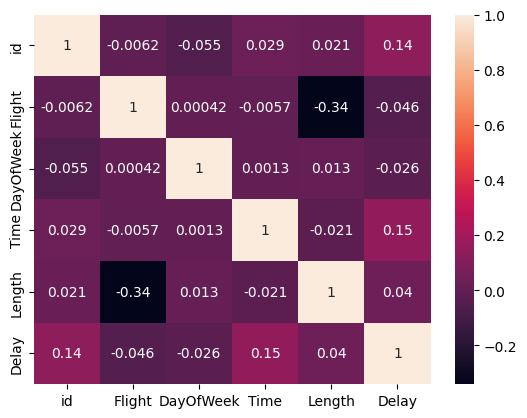

In [11]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

In [12]:
df

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0
...,...,...,...,...,...,...,...,...,...
539378,539379,CO,178,OGG,SNA,5,1439,326,0
539379,539380,FL,398,SEA,ATL,5,1439,305,0
539380,539381,FL,609,SFO,MKE,5,1439,255,0
539381,539382,UA,78,HNL,SFO,5,1439,313,1


In [ ]:
df["is_weekend"] = df["DayOfWeek"].isin([6,7]).astype(int)



In [ ]:
y = df["Delay"]

y.value_counts()


Delay
0    299119
1    240264
Name: count, dtype: int64

In [4]:

# Feature engineering simples
X = df.copy()

if "DepTime" in X.columns:
    dep = pd.to_numeric(X["DepTime"], errors="coerce")
    X["DepHour"] = ((dep // 100) % 24).astype("Int64")

if "DayOfWeek" in X.columns:
    X["is_weekend"] = X["DayOfWeek"].isin([6,7]).astype(int)
elif "day_of_week" in X.columns:
    X["is_weekend"] = X["day_of_week"].isin([6,7]).astype(int)
else:
    X["is_weekend"] = pd.NA

features = []
for col in ["Airline","DayOfWeek","Origin","Dest","Distance","DepHour","is_weekend"]:
    if col in X.columns:
        features.append(col)

X_model = X[features]
cat_features = [i for i,c in enumerate(X_model.columns) if X_model[c].dtype == 'object']
X_model.head()


,Airline,DayOfWeek,is_weekend
0,CO,3,0
1,US,3,0
2,AA,3,0
3,AA,3,0
4,AS,3,0


In [5]:

X_train, X_test, y_train, y_test = train_test_split(X_model, y, test_size=0.2, stratify=y, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

model = CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1, loss_function="Logloss", verbose=False)
model.fit(train_pool, eval_set=test_pool, verbose=False)

pred = model.predict(test_pool)
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))


Accuracy: 0.629846955328754
              precision    recall  f1-score   support

           0       0.62      0.85      0.72     59824
           1       0.66      0.35      0.46     48053

    accuracy                           0.63    107877
   macro avg       0.64      0.60      0.59    107877
weighted avg       0.64      0.63      0.60    107877

Confusion matrix:
 [[50919  8905]
 [31026 17027]]


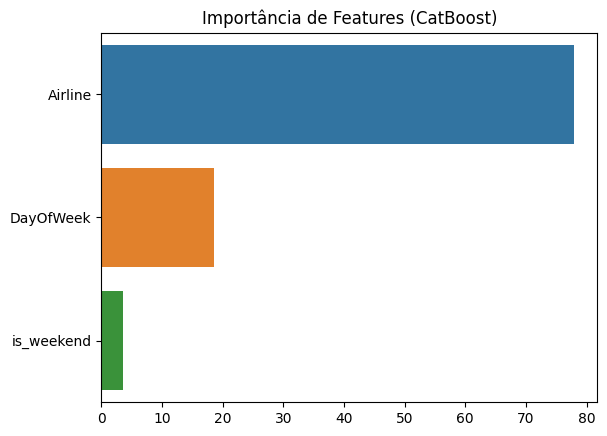

In [6]:

imp = pd.Series(model.get_feature_importance(test_pool), index=X_model.columns).sort_values(ascending=False)
sns.barplot(x=imp.values, y=imp.index)
plt.title("Importância de Features (CatBoost)")
plt.show()


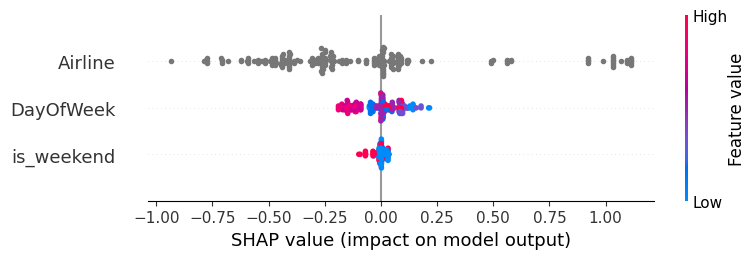

In [7]:

# SHAP analysis
sample_idx = np.random.RandomState(42).choice(len(X_test), size=min(200, len(X_test)), replace=False)
X_shap = X_test.iloc[sample_idx]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(shap_values, X_shap)


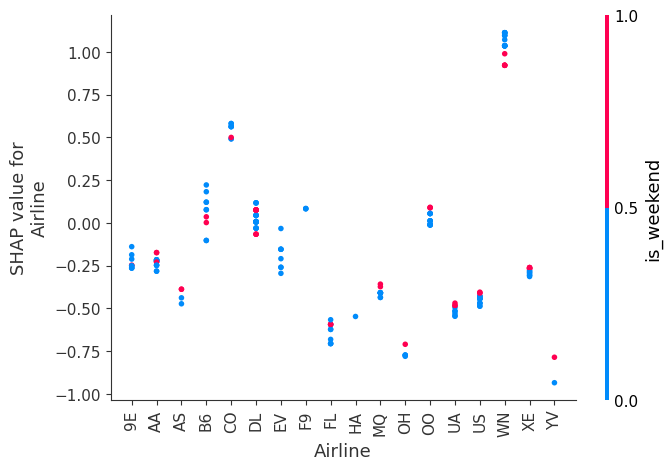

In [8]:

# Dependence plot para uma categórica
for c in X_shap.columns:
    if X_shap[c].dtype == 'object':
        shap.dependence_plot(c, shap_values, X_shap)
        break
